In [4]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Project'

In [3]:
%cd '/content/drive/My Drive/Project'

/content/drive/My Drive/Project


In [ ]:
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

tuberculosis-tb-chest-xray-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip && rm *.zip

**IMPORT LIBRARIES**

In [23]:
# necessary libraries
import os
import pandas as pd
import numpy as np
# visualizations libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# model evaluation libraries
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix


**EXPLORE DATASET** 

In [6]:
base_dir = '/content/drive/My Drive/Project/TB_Chest_Radiography_Database'
os.listdir(base_dir)

['Normal.metadata.xlsx',
 'README.md.txt',
 'Tuberculosis.metadata.xlsx',
 'Normal',
 'Tuberculosis']

In [7]:
tuberculosis_data= "/content/drive/My Drive/Project/TB_Chest_Radiography_Database/Tuberculosis"
print("tuberculosis images :\n" ,os.listdir(tuberculosis_data)[:6])

normal_data= "/content/drive/My Drive/Project/TB_Chest_Radiography_Database/Normal"
print("\n normal images :\n" ,os.listdir(normal_data)[:6])

tuberculosis images :
 ['Tuberculosis-3220.png', 'Tuberculosis-3186.png', 'Tuberculosis-3205.png', 'Tuberculosis-3189.png', 'Tuberculosis-3246.png', 'Tuberculosis-3123.png']

 normal images :
 ['Normal-3118.png', 'Normal-3149.png', 'Normal-3250.png', 'Normal-3207.png', 'Normal-3230.png', 'Normal-3209.png']


In [8]:
print("no. of tuberculosis images :" ,len(os.listdir(tuberculosis_data)))
print("\n no. of normal images :" ,len(os.listdir(normal_data)))

no. of tuberculosis images : 3500

 no. of normal images : 3500


**TAKE A LOOK OF THE IMAGES :**

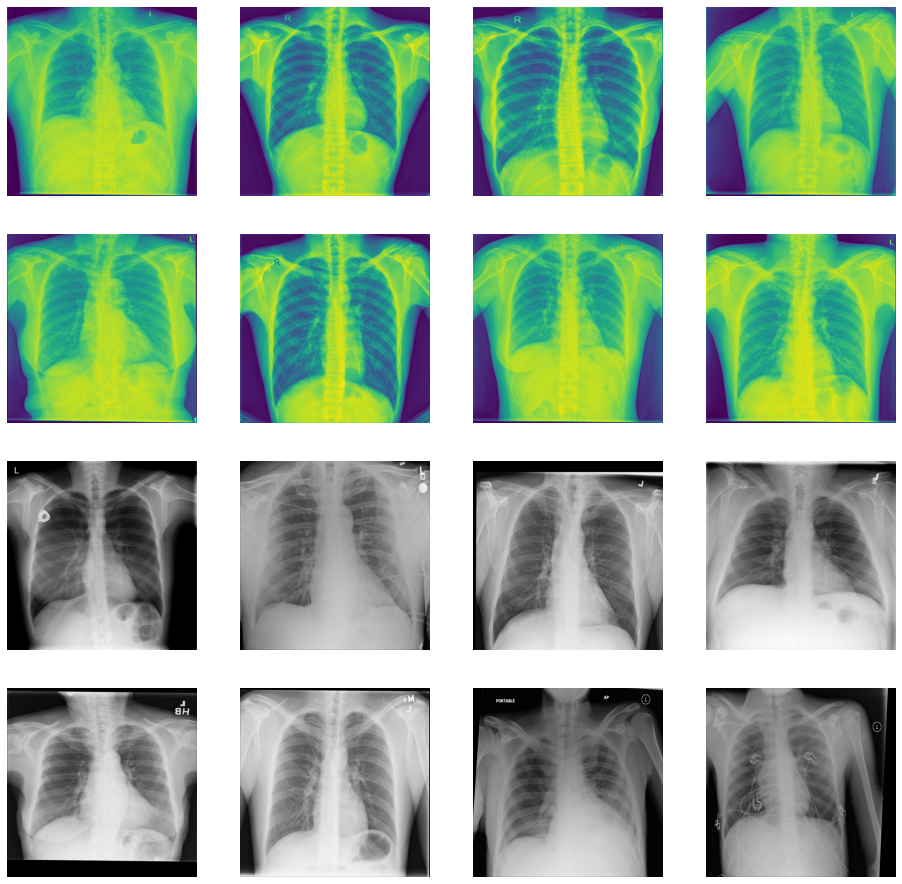

In [9]:
nrows= 4
ncols= 4
pic_index= 0

fig= plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8

tuberculosis_img = [os.path.join(tuberculosis_data, image) for image in os.listdir(tuberculosis_data)[pic_index-8:pic_index]]
normal_img = [os.path.join(normal_data, image) for image in os.listdir(normal_data)[pic_index-8:pic_index]]

for i, image_path in enumerate(tuberculosis_img+normal_img):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off') 

    img = mpimg.imread(image_path)
    plt.imshow(img)
plt.show()


In [10]:
image= imread("/content/drive/My Drive/Project/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-2422.png")
image.shape

(512, 512)

Generating Train & Validation set using Data Augmentation

In [11]:
# generating training data
print("training data :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50, width_shift_range= 0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split = 0.2)

train_data = train_datagen.flow_from_directory(base_dir, 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              subset= "training"
                                              )

# genarating validation data
print("\nvalidation data :")
val_datagen= ImageDataGenerator(rescale= 1/255, validation_split= 0.2)

val_data= train_datagen.flow_from_directory(base_dir, 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              shuffle= False,
                                              subset= "validation"
                                              )

training data :
Found 5600 images belonging to 2 classes.

validation data :
Found 1400 images belonging to 2 classes.


In [12]:
train_data.class_indices

{'Normal': 0, 'Tuberculosis': 1}

Model Building

Transfer Learning-InceptionV3 Model Inception v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge. Just as ImageNet can be thought of as a database of classified visual objects, Inception helps classification of objects in the world of computer vision. One such use is in life sciences, where it aids in the research of Leukemia. The original name (Inception) was codenamed this way after a popular "'we need to go deeper' internet meme" went viral, quoting a phrase from Inception film of Christopher Nolan.

In [13]:
# inceptionV3 model, with include_top= False we are not using fully connected layer of the inceptionV3 model, instead we
#  will create our own Fully Connected and Output Layer according to our training data
inception_model= InceptionV3(input_shape= (300, 300,3), include_top= False, weights="imagenet")

# Since we are creating our own fully connected layer we need output of the last inception model layer and flatten them 
last_output= inception_model.layers[-1].output

# Flattening the last output
last_output= Flatten()(last_output)

# Our pretrained model
pretrained_model= Model(inception_model.input, last_output)


87924736/87910968 [==============================] - 1s 0us/step


In [14]:
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Creating Dense Layer

In [15]:
# layer 1
x= Dense(units=512, activation="relu")(last_output)
x=Dropout(0.2)(x)

# layer 2
x= Dense(units=128, activation="relu")(x)
x=Dropout(0.2)(x)

# output layer
x= Dense(units=1, activation="sigmoid")(x)

# final model
model= Model(pretrained_model.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [16]:
# compile model
model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=["accuracy"])

# Since the layers of InceptionV3 model are already trained, we don't want them to be trained again. 
# So we will freeze these layers
for layer in pretrained_model.layers:
    layer.trainable= False

# model fitting
history= model.fit(train_data,
                   steps_per_epoch= train_data.samples//train_data.batch_size,
                   validation_data= val_data,
                   validation_steps= val_data.samples//val_data.batch_size,
                   epochs= 10,
                   verbose=1
                  )

Epoch 1/10
280/280 [==============================] - 2457s 9s/step - loss: 1.0109 - accuracy: 0.8421 - val_loss: 0.9375 - val_accuracy: 0.9243
Epoch 2/10
280/280 [==============================] - 210s 751ms/step - loss: 0.0808 - accuracy: 0.9786 - val_loss: 0.1854 - val_accuracy: 0.9857
Epoch 3/10
280/280 [==============================] - 212s 758ms/step - loss: 0.0897 - accuracy: 0.9867 - val_loss: 0.0533 - val_accuracy: 0.9871
Epoch 4/10
280/280 [==============================] - 212s 757ms/step - loss: 0.0351 - accuracy: 0.9898 - val_loss: 0.0902 - val_accuracy: 0.9893
Epoch 5/10
280/280 [==============================] - 212s 756ms/step - loss: 0.0382 - accuracy: 0.9909 - val_loss: 0.1453 - val_accuracy: 0.9793
Epoch 6/10
280/280 [==============================] - 211s 752ms/step - loss: 0.0414 - accuracy: 0.9931 - val_loss: 0.0295 - val_accuracy: 0.9914
Epoch 7/10
280/280 [==============================] - 211s 754ms/step - loss: 0.1513 - accuracy: 0.9928 - val_loss: 0.0638 - v

Model Evaluation

In [17]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

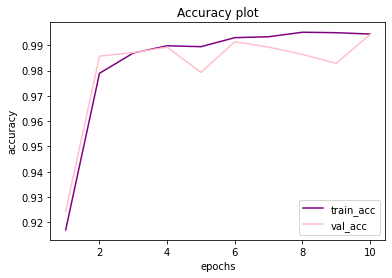

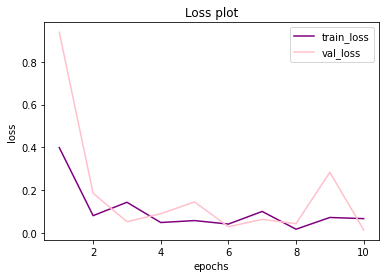

In [18]:
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()


Model performance

In [24]:
prediction= model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=1)
prediction= (prediction > 0.5)
prediction

70/70 [==============================] - 43s 529ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [25]:
val_labels=val_data.classes
val_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [26]:
prediction.shape


(1400, 1)

In [27]:
val_labels.shape

(1400,)

0.9914285714285714
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       700
           1       1.00      0.99      0.99       700

    accuracy                           0.99      1400
   macro avg       0.99      0.99      0.99      1400
weighted avg       0.99      0.99      0.99      1400



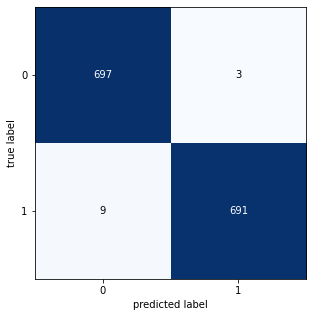

In [28]:
cm= confusion_matrix(val_data.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))

print(accuracy_score(val_data.classes, prediction))
print(classification_report(val_data.classes, prediction))


In [29]:

model.save("tuberculosis.h5")